# Import librairies

In [1]:
import os

seed = 42
os.environ["PYTHONHASHSEED"] = str(seed)

import sys
import random

sys.path.append("../utile")
sys.path.append("..")
from database import create_cnx, config_parse
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

path = "../data"
plt.rcParams["figure.figsize"] = (15, 15)
import base64

from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.cluster import (
    KMeans,
    AffinityPropagation,
    MeanShift,
    SpectralClustering,
    DBSCAN,
    OPTICS,
    Birch,
)
from sklearn.mixture import GaussianMixture

from data import DataSet

random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Loading data and utile functions

## Loading data from database

In [3]:
# Get the data from a given season and load it to a DataFrame
parser = config_parse()
cnx = create_cnx(parser)["cnx"]
curs = cnx.cursor()
season = "kharif"
sql_request = f"""SELECT * from data_SCOR WHERE Season = "{season}" ORDER BY RAND()"""
curs.execute(sql_request)
names = [x[0] for x in curs.description]
rows = curs.fetchall()
df = pd.DataFrame(rows, columns=names)

# Define all features which will be used in the models
numeric_features = [
    "Area_Sown_Ha",
    "Area_Insured_Ha",
    "SI_Per_Ha_Inr_Ha",
    "Sum_Insured_Inr",
    "Indemnity_Level",
]
textual_features = ["State", "District", "Sub_District", "Block", "Cluster", "Crop"]
dummies_features = ["Cluster", "Crop"]
clustering_features = [
    "State",
    "District",
    "Sub_District",
    "Block",
]

# Use a personnalized class which herits from pandas.DataFrame
df = DataSet(
    numeric_features=numeric_features,
    textual_features=textual_features,
    data=rows,
    columns=names,
)
# df = pd.DataFrame(rows, columns=names)
df.drop("id", inplace=True, axis=1)
df.dropna(axis=0, how="all", inplace=True)
# df.drop(axis=1,labels='index', inplace=True)

/appli/notebooks/../utile/data.py:60: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.numeric_features = numeric_features
/appli/notebooks/../utile/data.py:61: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.textual_features = textual_features
/appli/notebooks/../utile/data.py:63: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.values_list_to_replace = values_list_to_replace


# Preprocessing and encoding

## Pre-processing

In [5]:
# Keep only crop yields years with enough data
df.set_years_to_keep()
numeric_features += df.years_crop_yields
# Subset dataframe to keep only numeric features, textual features, and crop yields years
df.subset_data()
# Preprocess numeric features
df.pre_process_numeric()
# Preprocess textual features
df.preprocess_textual(subsample=False, thresh_representativty=False)

/appli/notebooks/../utile/data.py:88: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.years_crop_yields = [f"{year}_Yield" for year in years_to_keep]


In [7]:
# Dummification of some categorical features
dum_cols = []
for dum in dummies_features:
    dum_cols.append([f"{dum}_{elem}" for elem in pd.get_dummies(df[dum]).columns])
    df = pd.get_dummies(df, columns=[dum], prefix=dum, prefix_sep="_")
dum_cols = [i for elem in dum_cols for i in elem]

In [8]:
df.head(5)

,State,District,Sub_District,Block,Area_Sown_Ha,Area_Insured_Ha,SI_Per_Ha_Inr_Ha,Sum_Insured_Inr,Indemnity_Level,2006_Yield,...,Crop_soybean un-irr,Crop_sunflower,Crop_sunflower irr,Crop_sunflower un-irr,Crop_til (sesame),Crop_til (sesame) un-irr,Crop_tomato,Crop_turmeric,Crop_urad,Crop_urad un-irr
0,uttar pradesh,pratapgarh,lalganj,sangeepur,0.000000,-0.292107,-0.461173,3.342507e-08,-0.287354,-0.758472,...,0,0,0,0,0,0,0,0,1,0
1,maharashtra,nandurbar,taloda,taloda,0.000000,-0.122035,-0.656285,-2.231832e-01,-1.986284,-0.349308,...,0,0,0,0,0,0,0,0,0,0
2,uttar pradesh,shravasti,jamunaha,gilaula,0.000000,-0.293104,-1.412917,3.342507e-08,-0.287354,-0.573748,...,0,0,0,0,0,0,0,0,0,0
3,uttar pradesh,shahjahanpur,jalalabad,jalalabad,-0.509368,-0.292854,-1.739166,-2.931077e-01,-0.287354,-1.068808,...,0,0,0,0,1,0,0,0,0,0
4,uttar pradesh,budaun,sahaswan,shaswan,0.043584,-0.274864,-0.739943,-5.015272e-02,1.411575,0.196551,...,0,0,0,0,0,0,0,0,0,0


In [9]:
# Use a groupby function to get a clustering space
group = df.groupby(by=clustering_features)[numeric_features + dum_cols].mean()

In [12]:
len(group)

33473

# PCA and plot clustering

In [14]:
# Define a PCA of the dataset only for visualization
pca = PCA(n_components=2)
input_models = pca.fit_transform(group)

In [15]:
# Variance which is conserved is the PCA
pca.explained_variance_ratio_.sum()

0.7123752113689172

# Models

__Here is a quick fetch of some basic clustering models__

## K-Means

In [10]:
# Fetch a KMeans for a given number of clusters
n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters)
y_pred = kmeans.fit_predict(group)

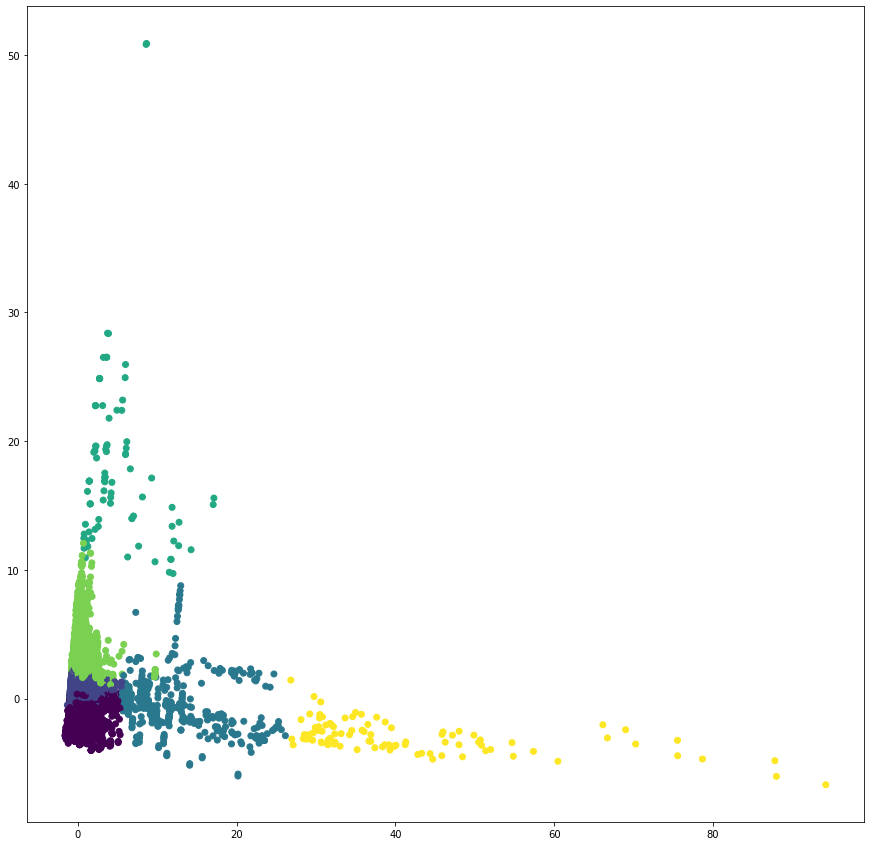

In [17]:
# Display clustering into the space from the PCA
plt.scatter(input_models[:, 0], input_models[:, 1], c=kmeans.labels_.astype(float))

In [11]:
# Value of the davies bouldin index
davies_bouldin_score(group, kmeans.predict(group))

1.269128762230818

In [55]:
# Plot the davies bouldin index for a range of number of clusters
kmeans_davies_bouldin_scores = []
for k in range(2, 20):
    model_kmeans = KMeans(k).fit(group)
    kmeans_davies_bouldin_scores.append(
        davies_bouldin_score(group, model_kmeans.predict(group))
    )

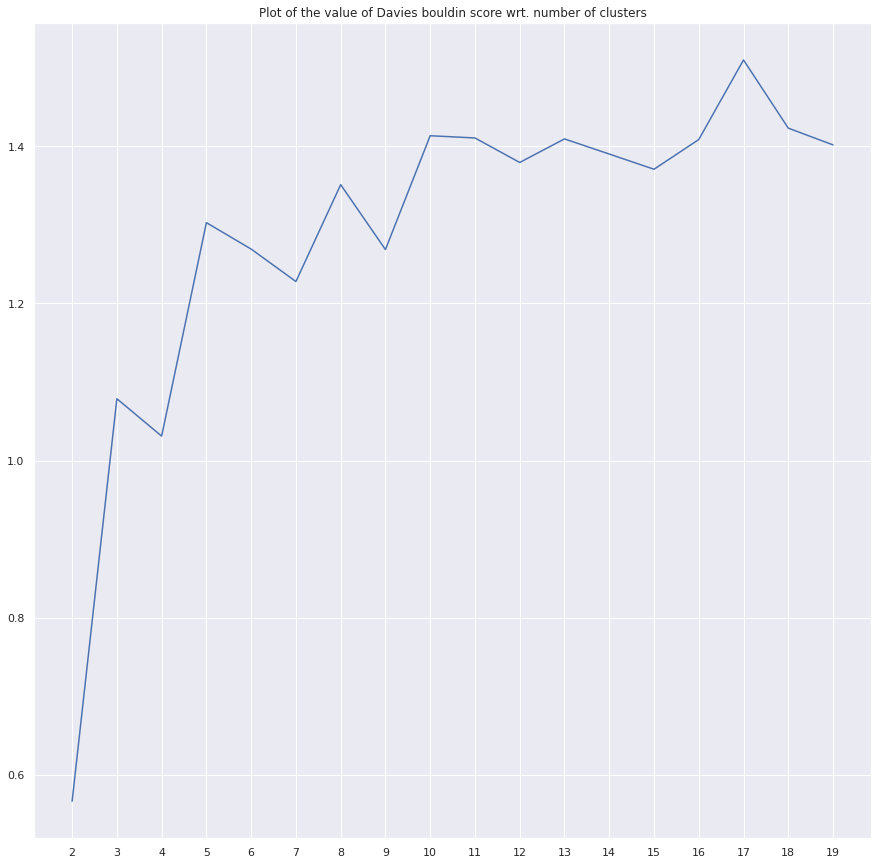

In [63]:
# Plot of the index
x = np.arange(2, 20)
y = kmeans_davies_bouldin_scores
sns.set_theme()
plt.plot(x, y)
plt.title("Plot of the value of Davies bouldin score wrt. number of clusters")
ticks = plt.xticks(np.arange(2, 20))

## DBSCAN

In [19]:
# DBSCAN model with default parameters
model_DBSCAN = DBSCAN().fit(group)

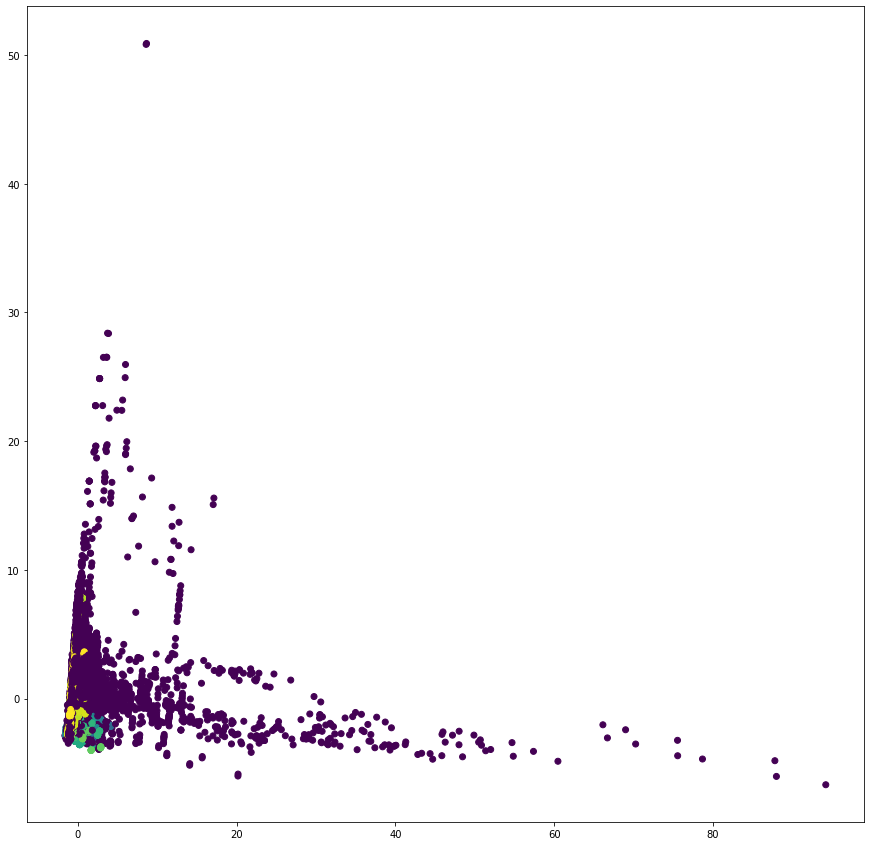

In [20]:
# Plot of the model
plt.scatter(
    input_models[:, 0], input_models[:, 1], c=model_DBSCAN.labels_.astype(float)
)

In [22]:
# Value of the davies bouldin index
davies_bouldin_score(group, model_DBSCAN.labels_.astype(int))

1.4265349046024607

## OPTICS

In [23]:
# OPTICS model with default configuration
model_OPTICS = OPTICS().fit(group)

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_optics.py:903: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


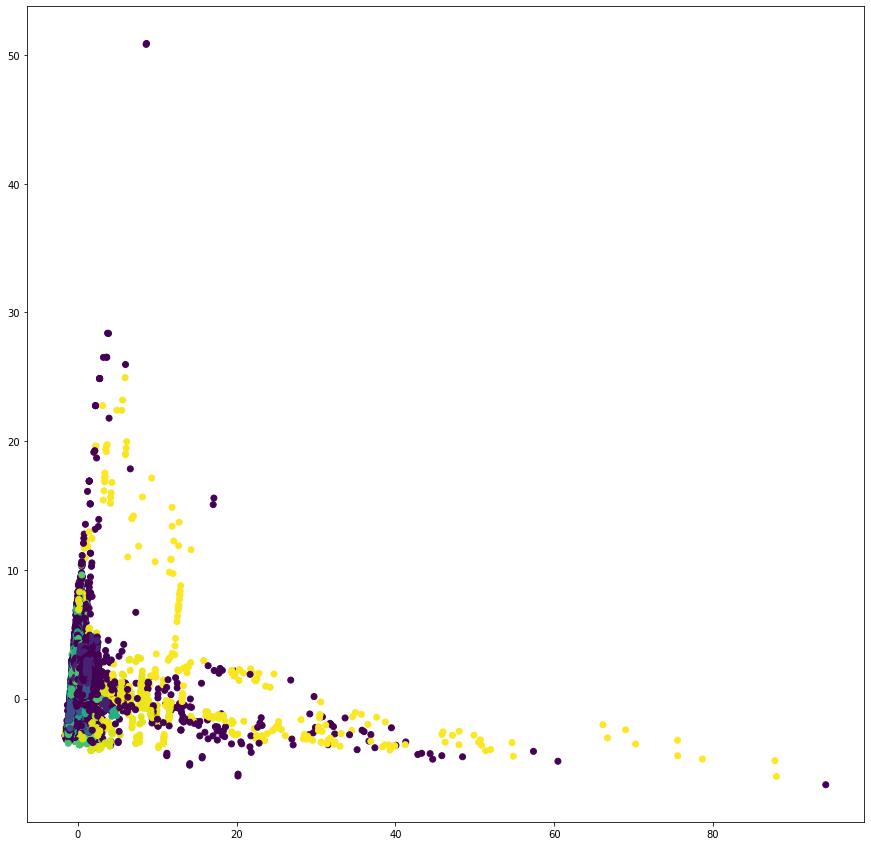

In [24]:
# Plot of the model
plt.scatter(
    input_models[:, 0], input_models[:, 1], c=model_OPTICS.labels_.astype(float)
)

In [26]:
# Value of the davies bouldin index
davies_bouldin_score(group, model_OPTICS.labels_.astype(int))

1.264568979460656

## Birch

In [52]:
model_Birch = Birch(n_clusters=6).fit(group)

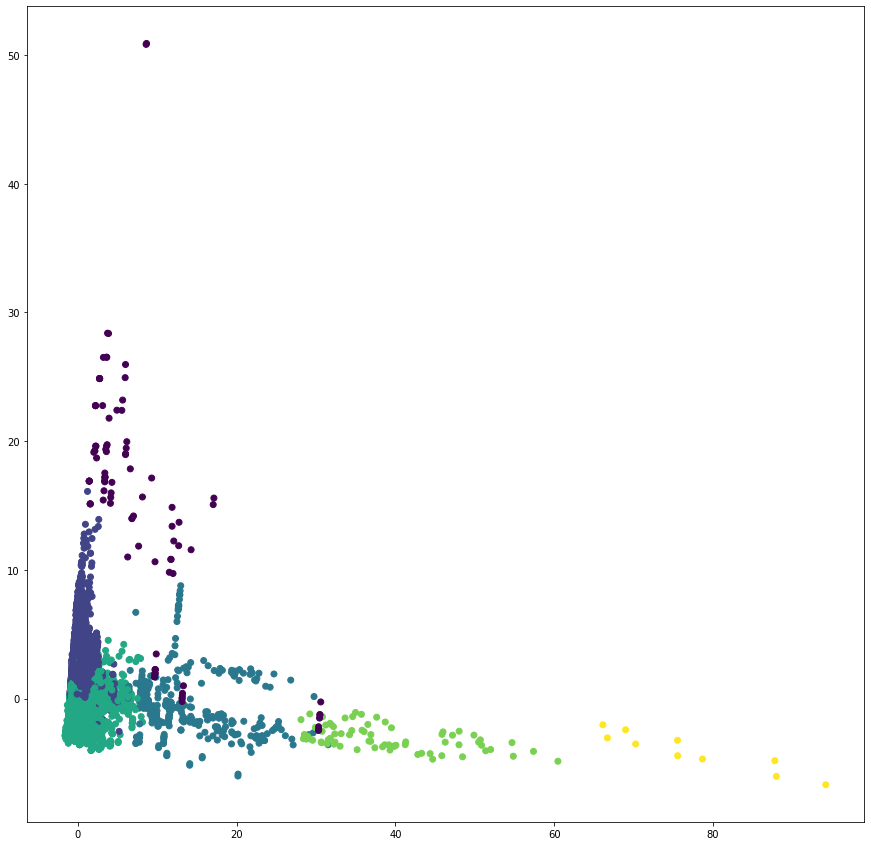

In [53]:
plt.scatter(input_models[:, 0], input_models[:, 1], c=model_Birch.labels_.astype(float))

In [54]:
davies_bouldin_score(group, model_Birch.predict(group))

1.0716628215097737

In [66]:
BIRCH_davies_bouldin_scores = []
for k in range(2, 20):
    model_Birch = Birch(n_clusters=k).fit(group)
    BIRCH_davies_bouldin_scores.append(
        davies_bouldin_score(group, model_Birch.predict(group))
    )

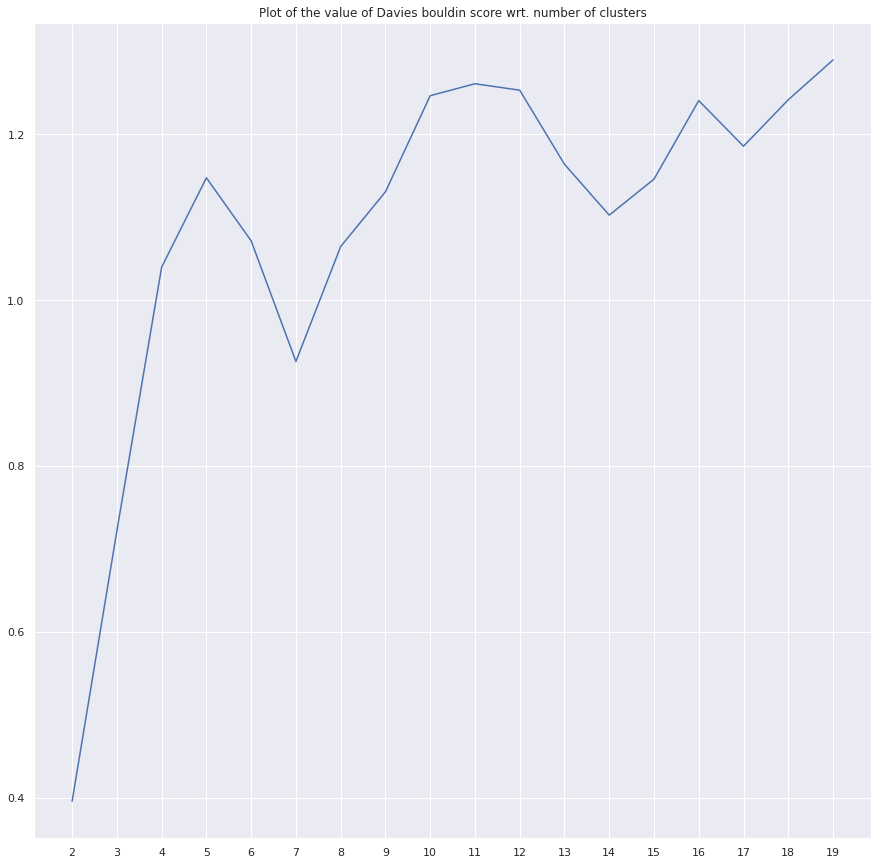

In [67]:
x = np.arange(2, 20)
y = BIRCH_davies_bouldin_scores
sns.set_theme()
plt.plot(x, y)
plt.title("Plot of the value of Davies bouldin score wrt. number of clusters")
ticks = plt.xticks(np.arange(2, 20))